# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [53]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [54]:
df = pd.read_csv('C:/Users/Iweimer/Desktop/BB_Git/1083-albumin-data-exploration/ML/GI_Bleed_Tables/blood_diseases_matched_alb_24h_full.csv')

In [55]:
df.LOS_hours.describe()

count    10388.000000
mean       251.110433
std        220.779942
min          6.916667
25%        101.175000
50%        174.862361
75%        320.020417
max       1292.800000
Name: LOS_hours, dtype: float64

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [56]:
df[df['albumin_24hrs'] == 1].LOS_hours.describe()

count    5194.000000
mean      271.705178
std       232.426587
min         7.666667
25%       111.766667
50%       192.904583
75%       355.579167
max      1292.800000
Name: LOS_hours, dtype: float64

In [57]:
df[df['albumin_24hrs'] == 0].LOS_hours.describe()

count    5194.000000
mean      230.515688
std       206.461579
min         6.916667
25%        95.654167
50%       162.588472
75%       287.824722
max      1292.413333
Name: LOS_hours, dtype: float64

## Convert LOS_Hours and ICU_LOS_hours Vars to Days Vars

In [58]:
df['LOS_days'] = df['LOS_hours']/24
df.drop(columns=['LOS_hours'], inplace=True)

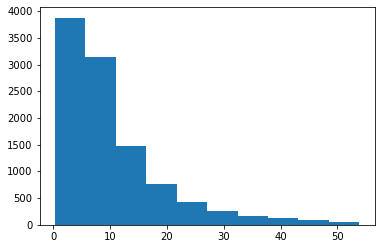

In [59]:
plt.hist(df['LOS_days']);

In [60]:
df['LOS_days'].describe()

count    10388.000000
mean        10.462935
std          9.199164
min          0.288194
25%          4.215625
50%          7.285932
75%         13.334184
max         53.866667
Name: LOS_days, dtype: float64

## Convert LOS_days to Categorical

In [61]:
# Calculate Tertiles

q1 = df['LOS_days'].quantile(q=(1/3))
q2 = df['LOS_days'].quantile(q=(2/3))
print(q1)
print(q2)

5.118626543209876
10.768055555555556


In [62]:
# bin the LOS_days var

LOS = df['LOS_days']
m = max(LOS)

bins = [0, 5.11, 10.8, m]
labels=[0, 1, 2]

# 0 - Low/Short Length of Stay
# 1 - Medium Length of Stay
# 2 - High/Long Length of Stay

df['LOS_days'] = pd.cut(LOS, bins=bins, labels=labels, include_lowest=True)

In [63]:
df['LOS_days'].value_counts()

1    3483
0    3454
2    3451
Name: LOS_days, dtype: int64

In [64]:
df.head()

encounterid  ICU  mass_transfusion  \
0  83aedaea-94b0-405c-a1ea-94fee7f50b52    1                 0   
1  b08d47a1-2a9e-4b7a-b008-f71641dcb93a    0                 0   
2  a3756a81-c2d1-41bd-831d-cc65e73299c6    1                 1   
3  d58ab90d-6928-4e32-af06-c3479e437faa    0                 0   
4  008fb547-53e0-467e-92b2-590982e390b8    1                 0   

   total_transfusions  anemia_status  CCI  bl_albumin_value  qSOFA  Cirrhosis  \
0                   0            0.0    4               3.5      1          0   
1                   0            0.0    2               3.9      0          0   
2                   0            0.0    1               3.5      1          0   
3                   0            2.0    4               2.2      0          1   
4                   1            2.0    6               3.3      1          0   

   beta_blocker  hemorrhagic  SAPS  propensity_score  propensity_logit  \
0             1            0    34          0.492114         -0.031547   
1             1            0    41          0.296393         -0.864535   
2             0            0    29          0.615716          0.471403   
3             1            1    31          0.784942          1.294700   
4             1            1    20          0.509232          0.036933   

   albumin_24hrs                              personid  30_day_mortality  \
0              1  1df390c3-18b8-41b0-acd9-23495059e97a                 0   
1              1  1f7e4dd3-9985-4039-8099-ecea6ec7b94d                 0   
2              1  3cc07cf0-d9b1-486a-a33f-7a0db69304dd                 1   
3              1  3e61e48c-91d7-466b-8dff-89c791002dc6                 0   
4              1  43c7671f-8311-40d6-861f-91e668874c01                 0   

   30_day_readmission LOS_days  
0                   1        2  
1                   0        2  
2                   0        0  
3                   1        1  
4                   0        1

In [65]:
df.shape

(10388, 19)

In [66]:
df.drop(columns=['personid', 'encounterid', '30_day_readmission', '30_day_mortality', 'propensity_score', 'propensity_logit'], inplace=True)

In [67]:
df.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  \
0    1                 0                   0            0.0    4   
1    0                 0                   0            0.0    2   
2    1                 1                   0            0.0    1   
3    0                 0                   0            2.0    4   
4    1                 0                   1            2.0    6   

   bl_albumin_value  qSOFA  Cirrhosis  beta_blocker  hemorrhagic  SAPS  \
0               3.5      1          0             1            0    34   
1               3.9      0          0             1            0    41   
2               3.5      1          0             0            0    29   
3               2.2      0          1             1            1    31   
4               3.3      1          0             1            1    20   

   albumin_24hrs LOS_days  
0              1        2  
1              1        2  
2              1        0  
3              1        1  
4              1        1

In [68]:
# remove variables

# df.drop(columns=['anemia_status', 'SAPS', 'qSOFA', 'mass_transfusion'], inplace=True)

In [69]:
df.describe()

ICU  mass_transfusion  total_transfusions  anemia_status  \
count  10388.000000      10388.000000        10388.000000   10388.000000   
mean       0.313150          0.064497            0.576146       1.731806   
std        0.463797          0.245649            0.949519       1.098535   
min        0.000000          0.000000            0.000000       0.000000   
25%        0.000000          0.000000            0.000000       1.000000   
50%        0.000000          0.000000            0.000000       2.000000   
75%        1.000000          0.000000            1.000000       3.000000   
max        1.000000          1.000000            5.000000       3.000000   

                CCI  bl_albumin_value         qSOFA     Cirrhosis  \
count  10388.000000      10388.000000  10388.000000  10388.000000   
mean       5.108009          2.629347      0.883038      0.538987   
std        2.767573          0.695624      0.829843      0.498502   
min        0.000000          0.002700      0.000000      0.000000   
25%        3.000000          2.100000      0.000000      0.000000   
50%        5.000000          2.600000      1.000000      1.000000   
75%        7.000000          3.100000      1.000000      1.000000   
max       18.000000          5.300000      3.000000      1.000000   

       beta_blocker   hemorrhagic          SAPS  albumin_24hrs  
count  10388.000000  10388.000000  10388.000000   10388.000000  
mean       0.362052      0.172122     33.264440       0.500000  
std        0.480617      0.377504     12.851008       0.500024  
min        0.000000      0.000000      0.000000       0.000000  
25%        0.000000      0.000000     24.000000       0.000000  
50%        0.000000      0.000000     32.000000       0.500000  
75%        1.000000      0.000000     42.000000       1.000000  
max        1.000000      1.000000     64.000000       1.000000

In [70]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [71]:
# establish target feature, LOS_days, as y feature
y = df['LOS_days']
# drop target feature from features dataframe
X = df.drop(columns = ['LOS_days'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [72]:
cols

Index(['ICU', 'mass_transfusion', 'total_transfusions', 'anemia_status', 'CCI',
       'bl_albumin_value', 'qSOFA', 'Cirrhosis', 'beta_blocker', 'hemorrhagic',
       'SAPS', 'albumin_24hrs'],
      dtype='object')

## Standardize Data

In [73]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [74]:
X.head()

ICU  mass_transfusion  total_transfusions  anemia_status  CCI  \
0    1                 0                   0            0.0    4   
1    0                 0                   0            0.0    2   
2    1                 1                   0            0.0    1   
3    0                 0                   0            2.0    4   
4    1                 0                   1            2.0    6   

   bl_albumin_value  qSOFA  Cirrhosis  beta_blocker  hemorrhagic  SAPS  \
0               3.5      1          0             1            0    34   
1               3.9      0          0             1            0    41   
2               3.5      1          0             0            0    29   
3               2.2      0          1             1            1    31   
4               3.3      1          0             1            1    20   

   albumin_24hrs  
0              1  
1              1  
2              1  
3              1  
4              1

## Train Test Split

In [75]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [37]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: -0.14626
Feature: total_transfusions Score: 0.00279
Feature: CCI Score: -0.04979
Feature: bl_albumin_value Score: 0.10218
Feature: Cirrhosis Score: 0.23890
Feature: beta_blocker Score: -0.19154
Feature: hemorrhagic Score: -0.22577
Feature: albumin_24hrs Score: -0.25964


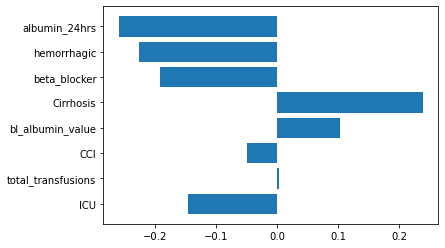

In [38]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

                    Importance
Cirrhosis             1.269846
bl_albumin_value      1.107586
total_transfusions    1.002796
CCI                   0.951431
ICU                   0.863934
beta_blocker          0.825683
hemorrhagic           0.797898
albumin_24hrs         0.771329


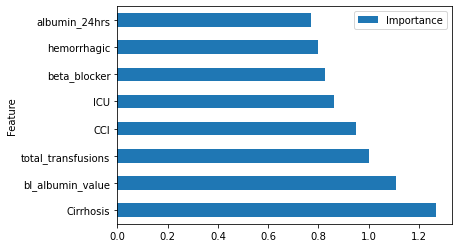

In [39]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [40]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [41]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1460  434  858]
 [1169  516 1111]
 [ 934  494 1334]]


In [42]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.41      0.53      0.46      2752
           1       0.36      0.18      0.24      2796
           2       0.40      0.48      0.44      2762

    accuracy                           0.40      8310
   macro avg       0.39      0.40      0.38      8310
weighted avg       0.39      0.40      0.38      8310



In [43]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[372 119 211]
 [266 121 300]
 [218 124 347]]


In [44]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.43      0.53      0.48       702
           1       0.33      0.18      0.23       687
           2       0.40      0.50      0.45       689

    accuracy                           0.40      2078
   macro avg       0.39      0.40      0.39      2078
weighted avg       0.39      0.40      0.39      2078



## 1: Decision Tree (Max Depth=3)

In [76]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=3)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.11738
Feature: total_transfusions Score: 0.00000
Feature: anemia_status Score: 0.33177
Feature: CCI Score: 0.05050
Feature: bl_albumin_value Score: 0.00000
Feature: qSOFA Score: 0.08357
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.00000
Feature: hemorrhagic Score: 0.00000
Feature: SAPS Score: 0.19621
Feature: albumin_24hrs Score: 0.22057


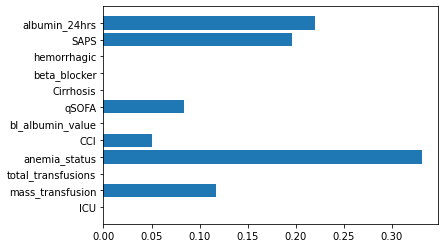

In [77]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [78]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [79]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1141  532 1079]
 [ 858  588 1350]
 [ 690  394 1678]]


In [80]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.42      0.41      0.42      2752
           1       0.39      0.21      0.27      2796
           2       0.41      0.61      0.49      2762

    accuracy                           0.41      8310
   macro avg       0.41      0.41      0.39      8310
weighted avg       0.41      0.41      0.39      8310



In [81]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[285 132 285]
 [218 143 326]
 [181  87 421]]


In [82]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.42      0.41      0.41       702
           1       0.40      0.21      0.27       687
           2       0.41      0.61      0.49       689

    accuracy                           0.41      2078
   macro avg       0.41      0.41      0.39      2078
weighted avg       0.41      0.41      0.39      2078



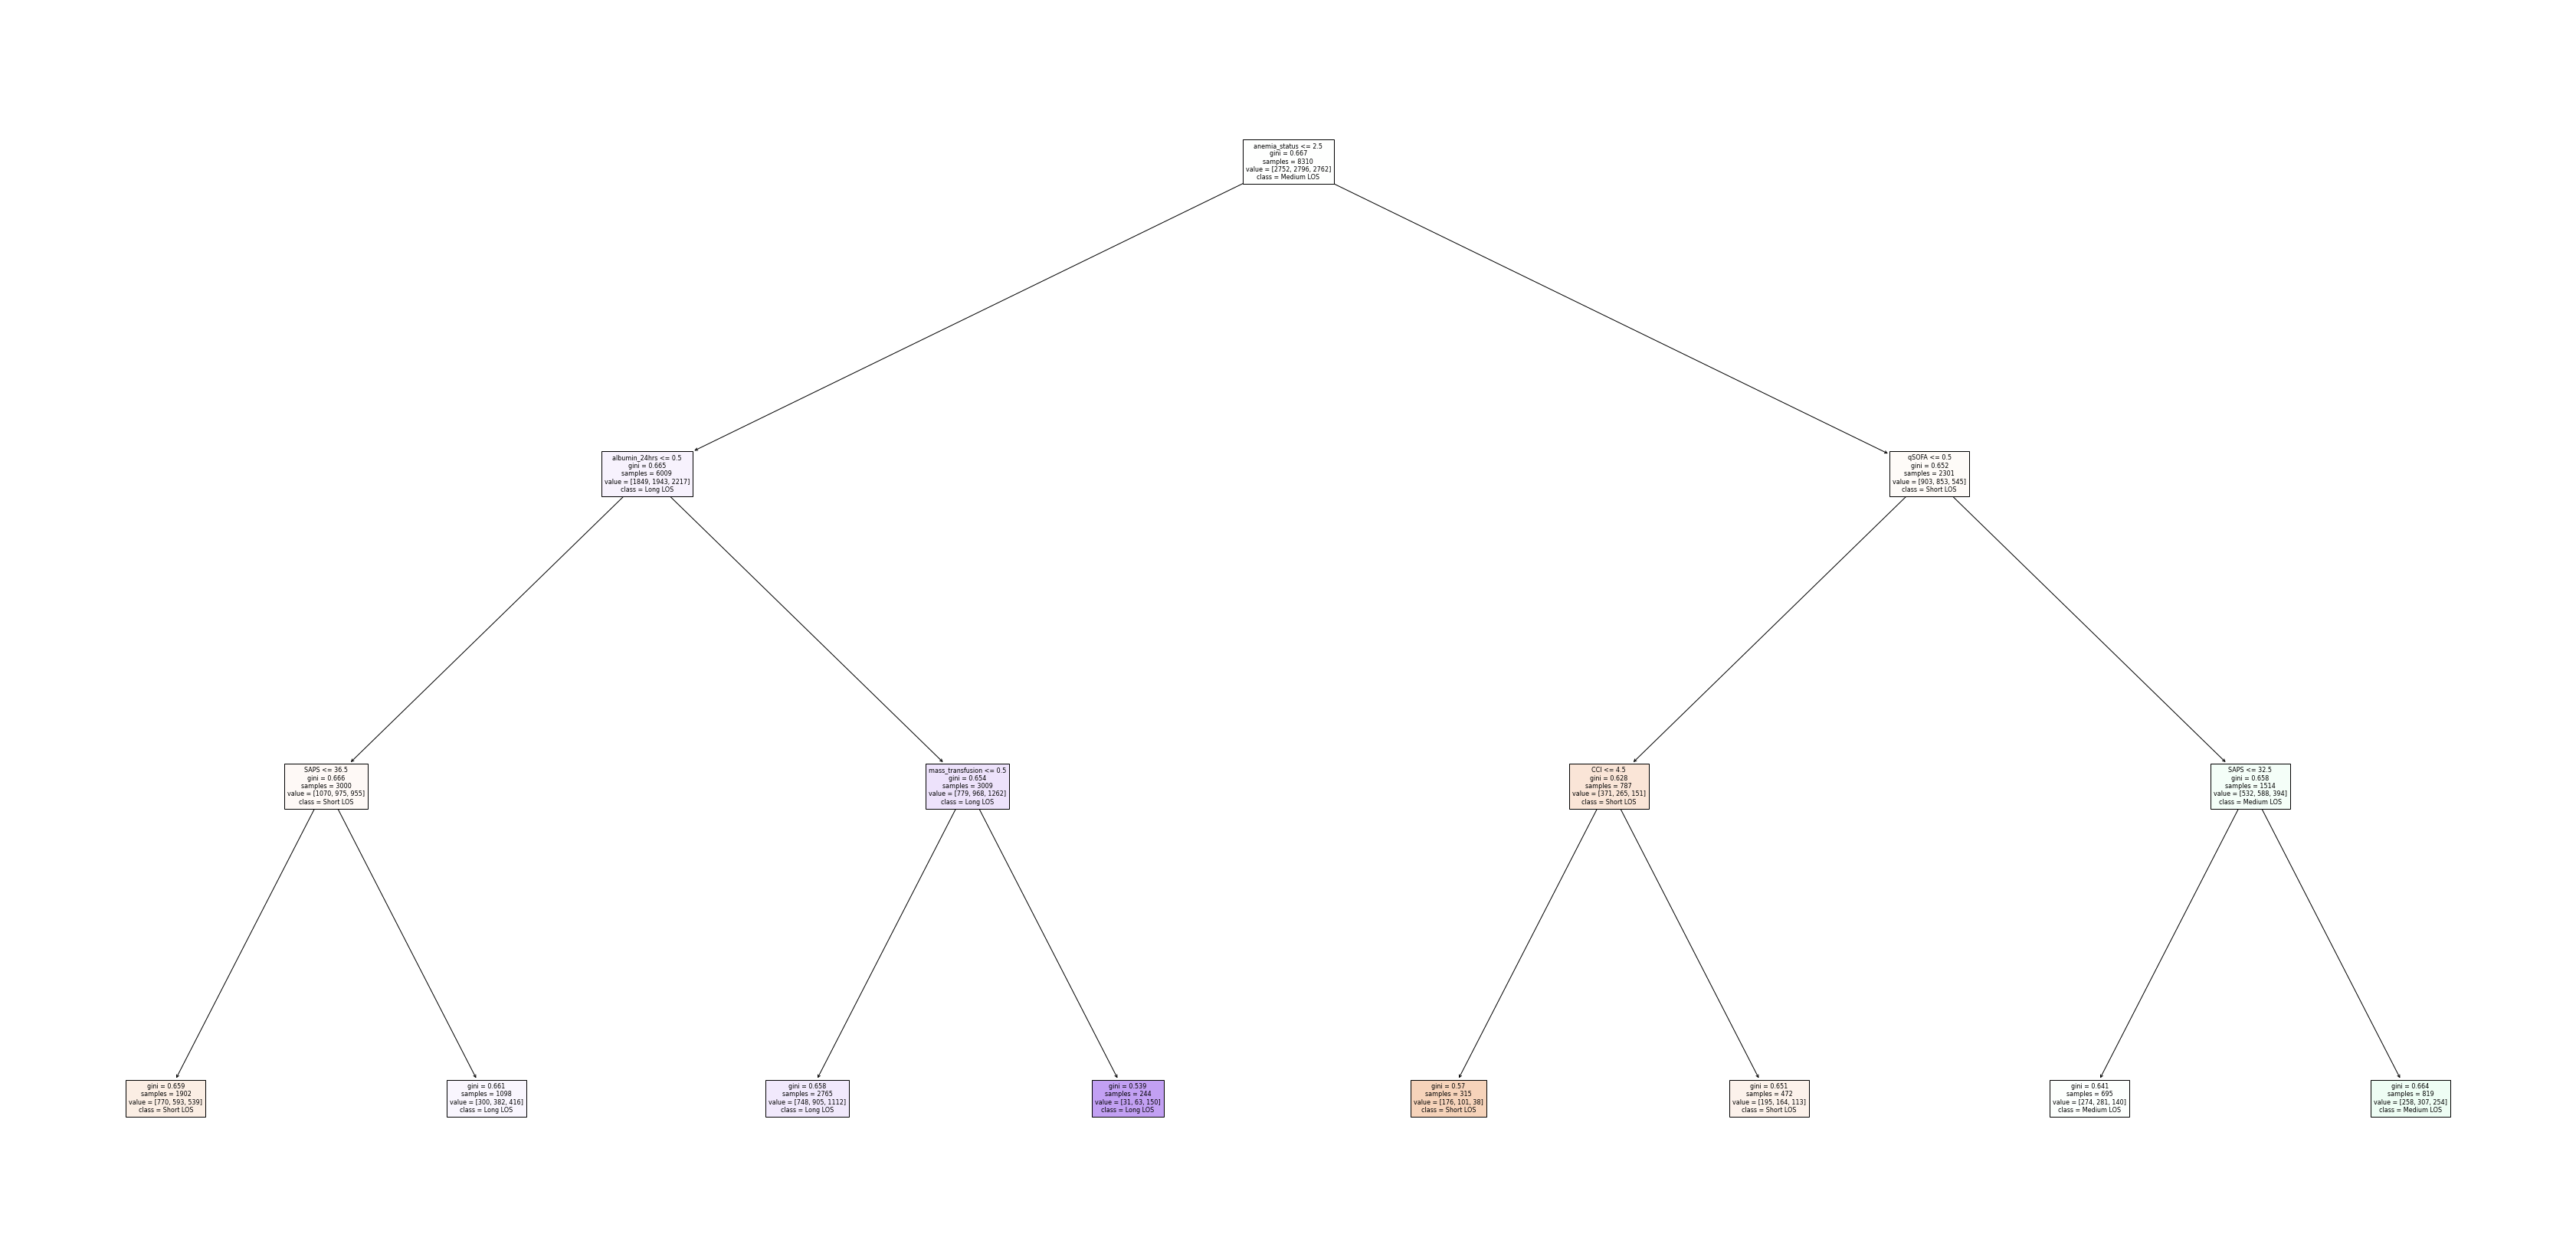

In [83]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [30]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.write_png('LOS_DT_D3_NCBL.png')

True

## 2: Decision Tree (Max Depth=4)

In [84]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
dt = tree.DecisionTreeClassifier(max_depth=4)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

Feature: ICU Score: 0.00000
Feature: mass_transfusion Score: 0.10922
Feature: total_transfusions Score: 0.03365
Feature: anemia_status Score: 0.23599
Feature: CCI Score: 0.16011
Feature: bl_albumin_value Score: 0.00000
Feature: qSOFA Score: 0.05944
Feature: Cirrhosis Score: 0.00000
Feature: beta_blocker Score: 0.02577
Feature: hemorrhagic Score: 0.04363
Feature: SAPS Score: 0.17529
Feature: albumin_24hrs Score: 0.15690


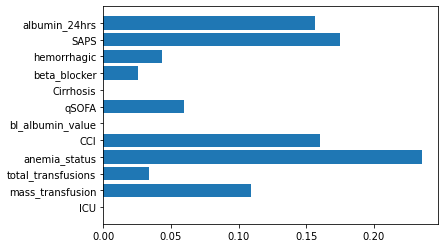

In [85]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [86]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [87]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1273  464 1015]
 [ 965  579 1252]
 [ 640  464 1658]]


In [88]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45      2752
           1       0.38      0.21      0.27      2796
           2       0.42      0.60      0.50      2762

    accuracy                           0.42      8310
   macro avg       0.42      0.42      0.41      8310
weighted avg       0.42      0.42      0.41      8310



In [89]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[310 129 263]
 [246 119 322]
 [184 110 395]]


In [90]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.42      0.44      0.43       702
           1       0.33      0.17      0.23       687
           2       0.40      0.57      0.47       689

    accuracy                           0.40      2078
   macro avg       0.38      0.40      0.38      2078
weighted avg       0.39      0.40      0.38      2078



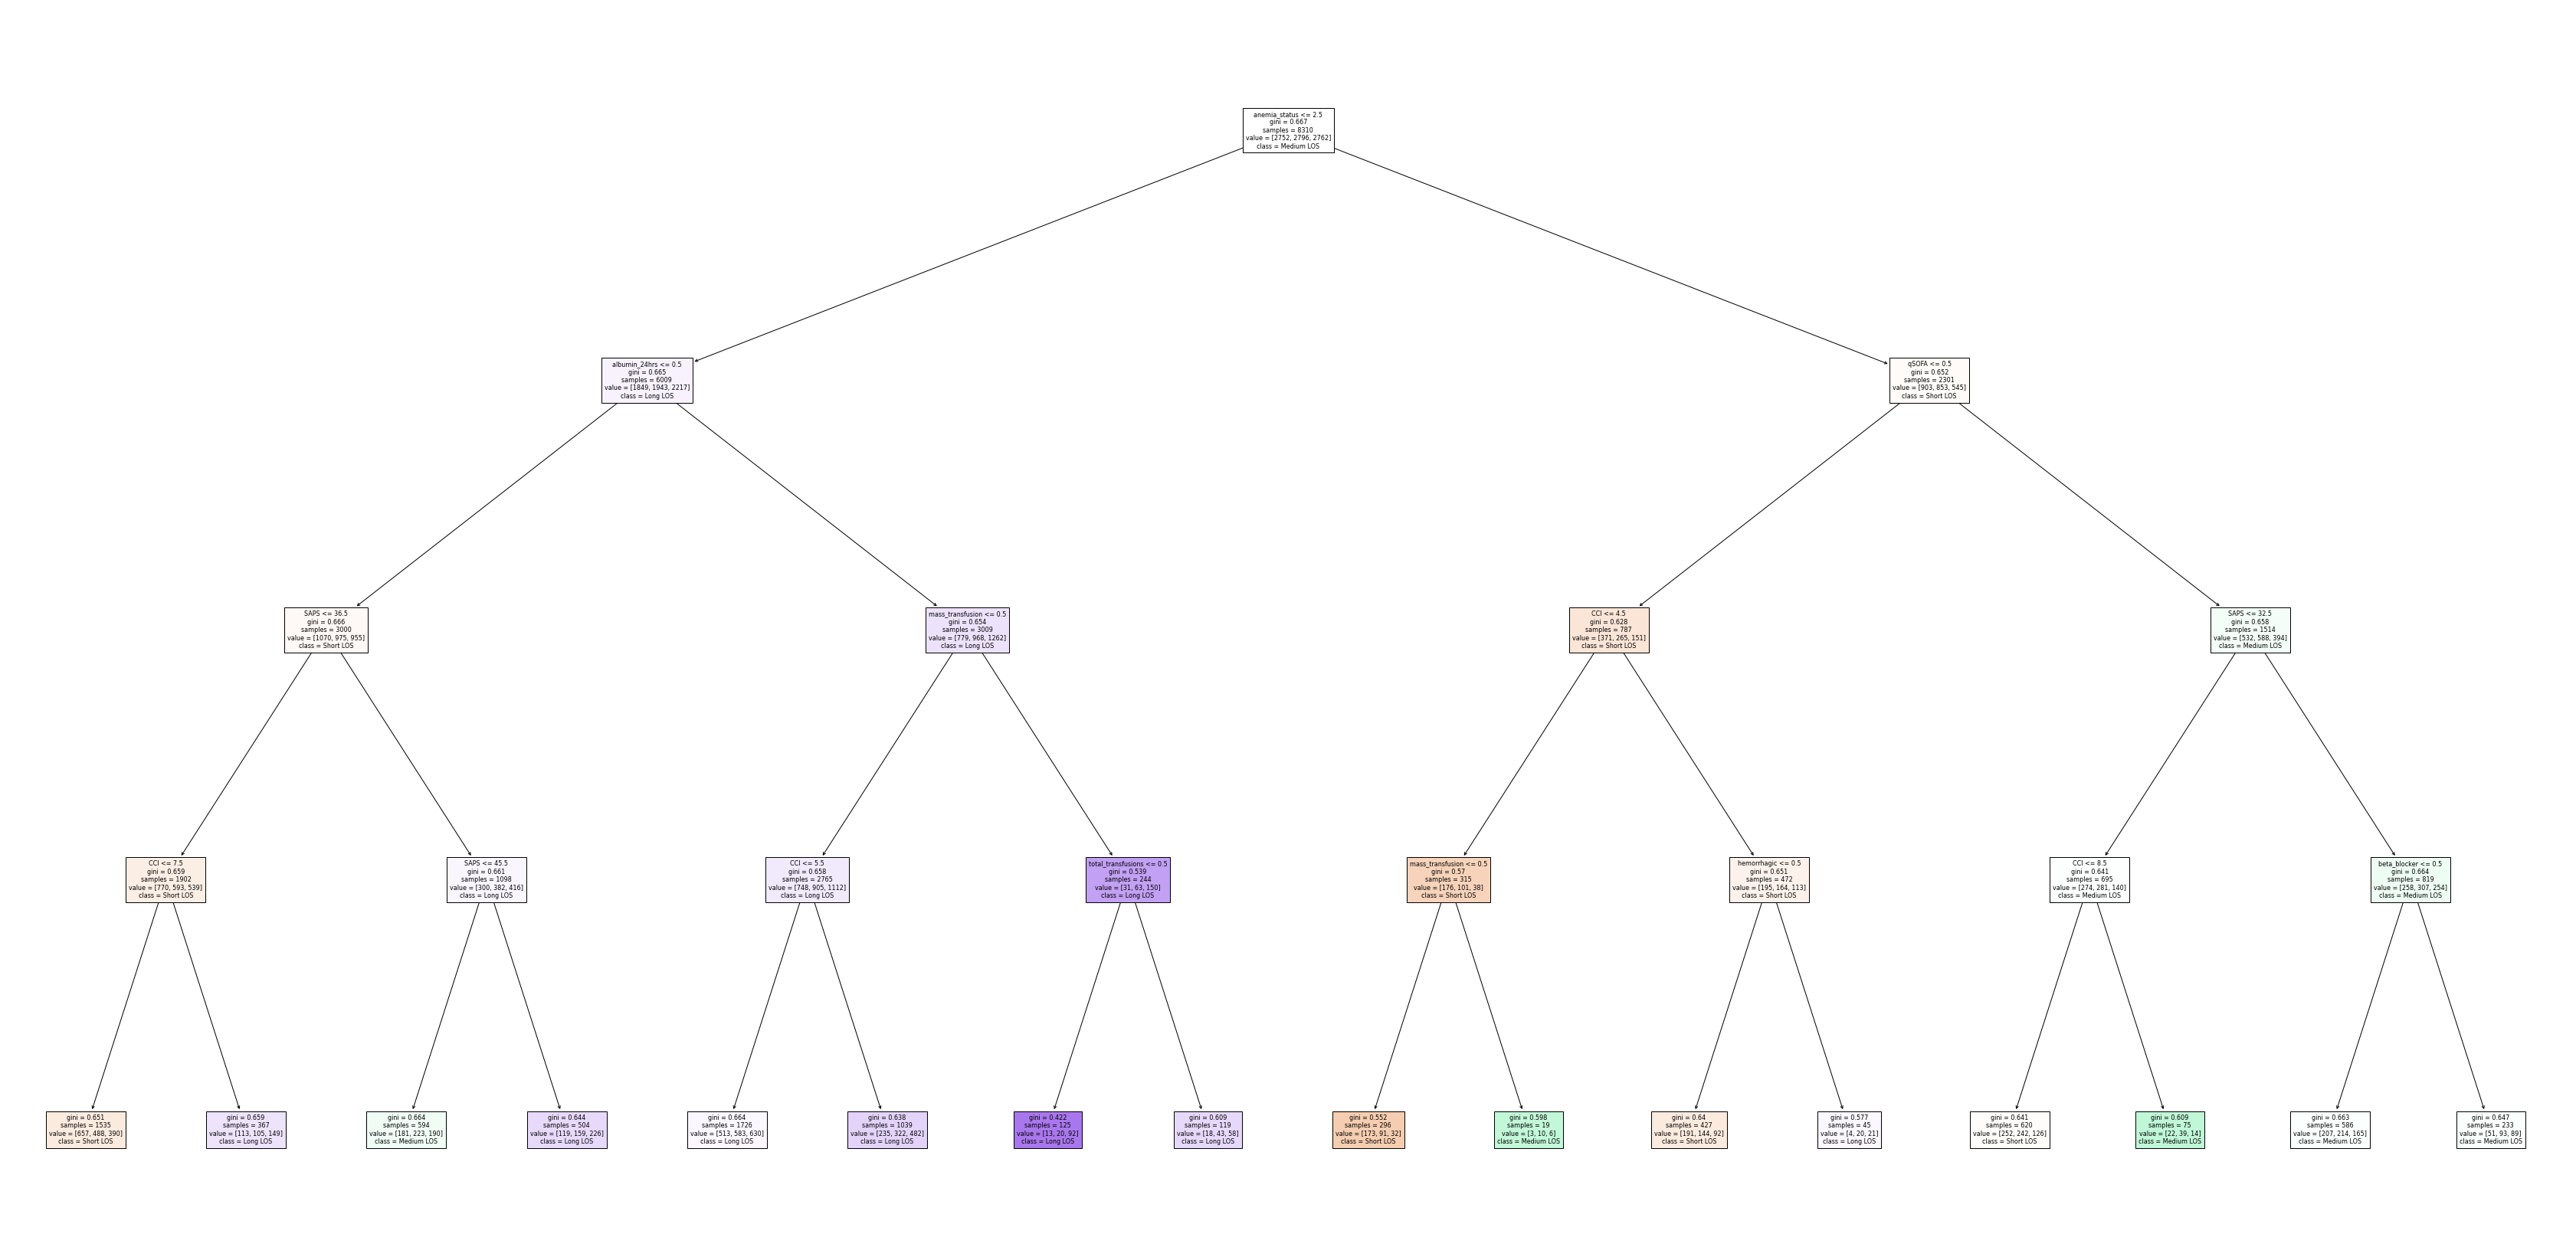

In [91]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [39]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D4_NCBL.png')

True

## 3: Decision Tree 

In [92]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=5)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

Feature: ICU Score: 0.00983
Feature: mass_transfusion Score: 0.07804
Feature: total_transfusions Score: 0.03222
Feature: anemia_status Score: 0.21621
Feature: CCI Score: 0.13547
Feature: bl_albumin_value Score: 0.08064
Feature: qSOFA Score: 0.05679
Feature: Cirrhosis Score: 0.01705
Feature: beta_blocker Score: 0.04333
Feature: hemorrhagic Score: 0.04623
Feature: SAPS Score: 0.17210
Feature: albumin_24hrs Score: 0.11210


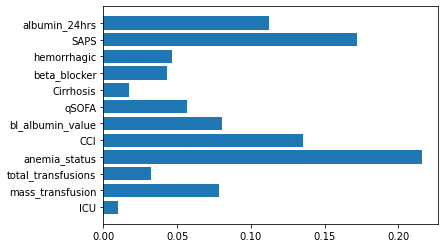

In [93]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [94]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [95]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1325  792  635]
 [ 998  959  839]
 [ 668  774 1320]]


In [96]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.44      0.48      0.46      2752
           1       0.38      0.34      0.36      2796
           2       0.47      0.48      0.48      2762

    accuracy                           0.43      8310
   macro avg       0.43      0.43      0.43      8310
weighted avg       0.43      0.43      0.43      8310



In [97]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[317 220 165]
 [241 217 229]
 [192 183 314]]


In [98]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.42      0.45      0.44       702
           1       0.35      0.32      0.33       687
           2       0.44      0.46      0.45       689

    accuracy                           0.41      2078
   macro avg       0.41      0.41      0.41      2078
weighted avg       0.41      0.41      0.41      2078



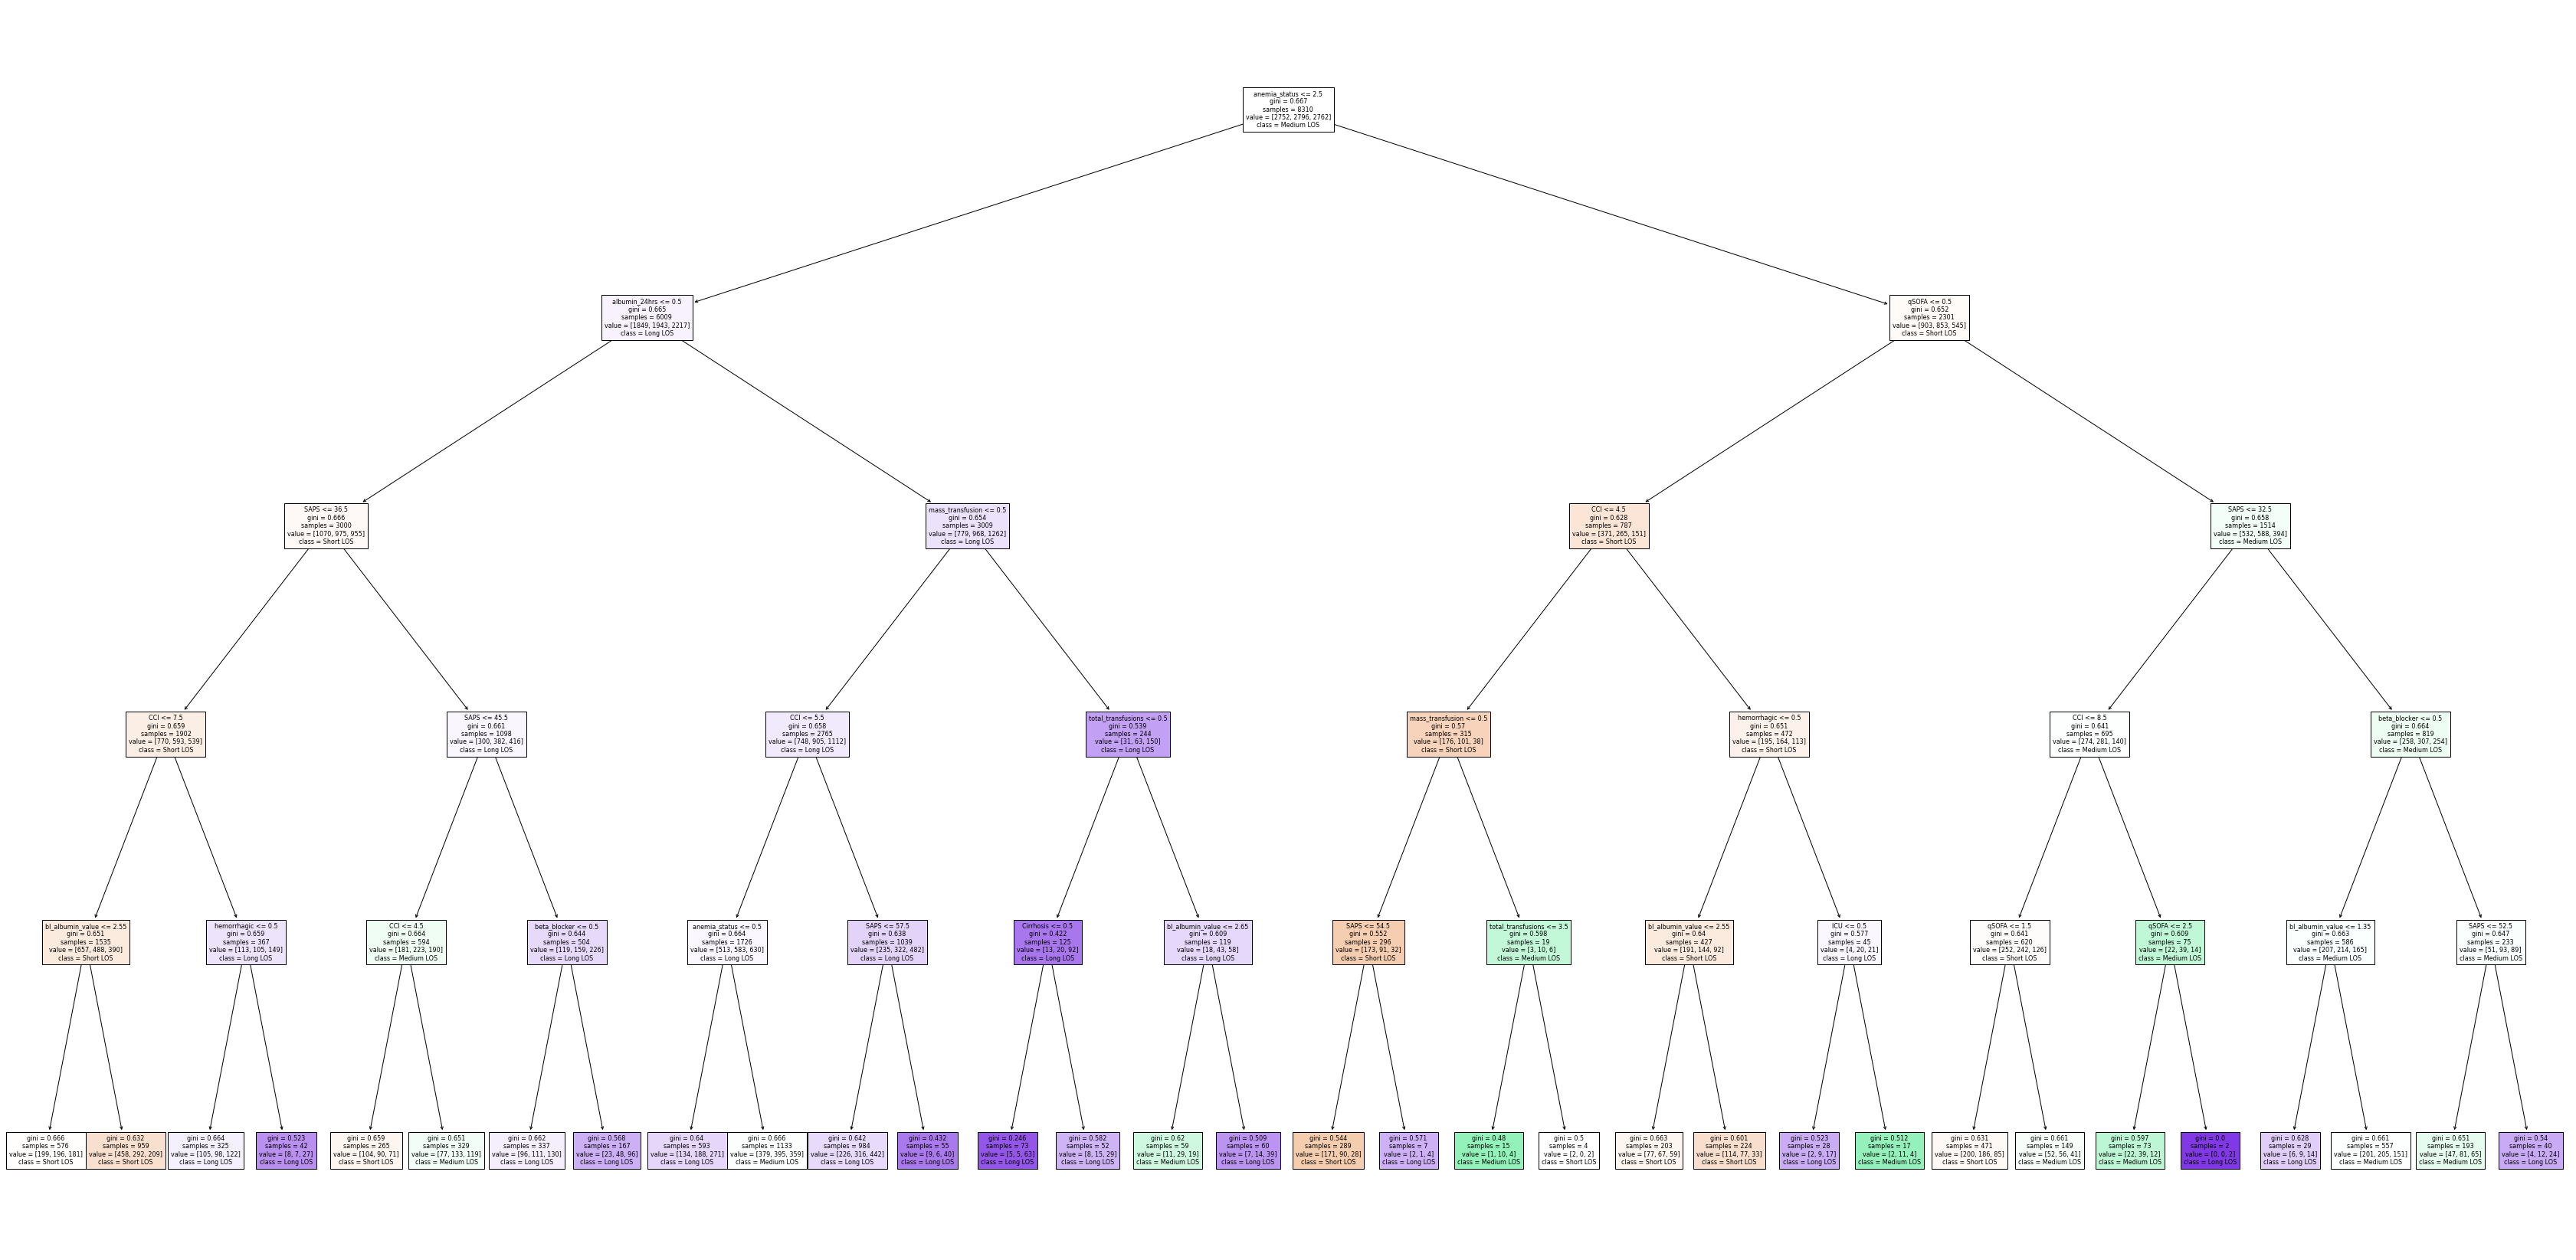

In [99]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [48]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D5_NCBL.png')

True

## 4: Decision Tree 

In [100]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

Feature: ICU Score: 0.01025
Feature: mass_transfusion Score: 0.05803
Feature: total_transfusions Score: 0.02339
Feature: anemia_status Score: 0.21438
Feature: CCI Score: 0.13059
Feature: bl_albumin_value Score: 0.07302
Feature: qSOFA Score: 0.09098
Feature: Cirrhosis Score: 0.02269
Feature: beta_blocker Score: 0.04968
Feature: hemorrhagic Score: 0.00718
Feature: SAPS Score: 0.20860
Feature: albumin_24hrs Score: 0.11121


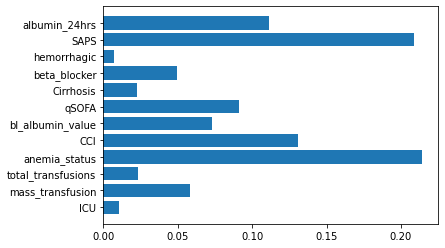

In [101]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [102]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [103]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1411  620  721]
 [1021  794  981]
 [ 704  578 1480]]


In [104]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.45      0.51      0.48      2752
           1       0.40      0.28      0.33      2796
           2       0.47      0.54      0.50      2762

    accuracy                           0.44      8310
   macro avg       0.44      0.44      0.44      8310
weighted avg       0.44      0.44      0.44      8310



In [105]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[363 166 173]
 [256 167 264]
 [194 140 355]]


In [106]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.45      0.52      0.48       702
           1       0.35      0.24      0.29       687
           2       0.45      0.52      0.48       689

    accuracy                           0.43      2078
   macro avg       0.42      0.43      0.42      2078
weighted avg       0.42      0.43      0.42      2078



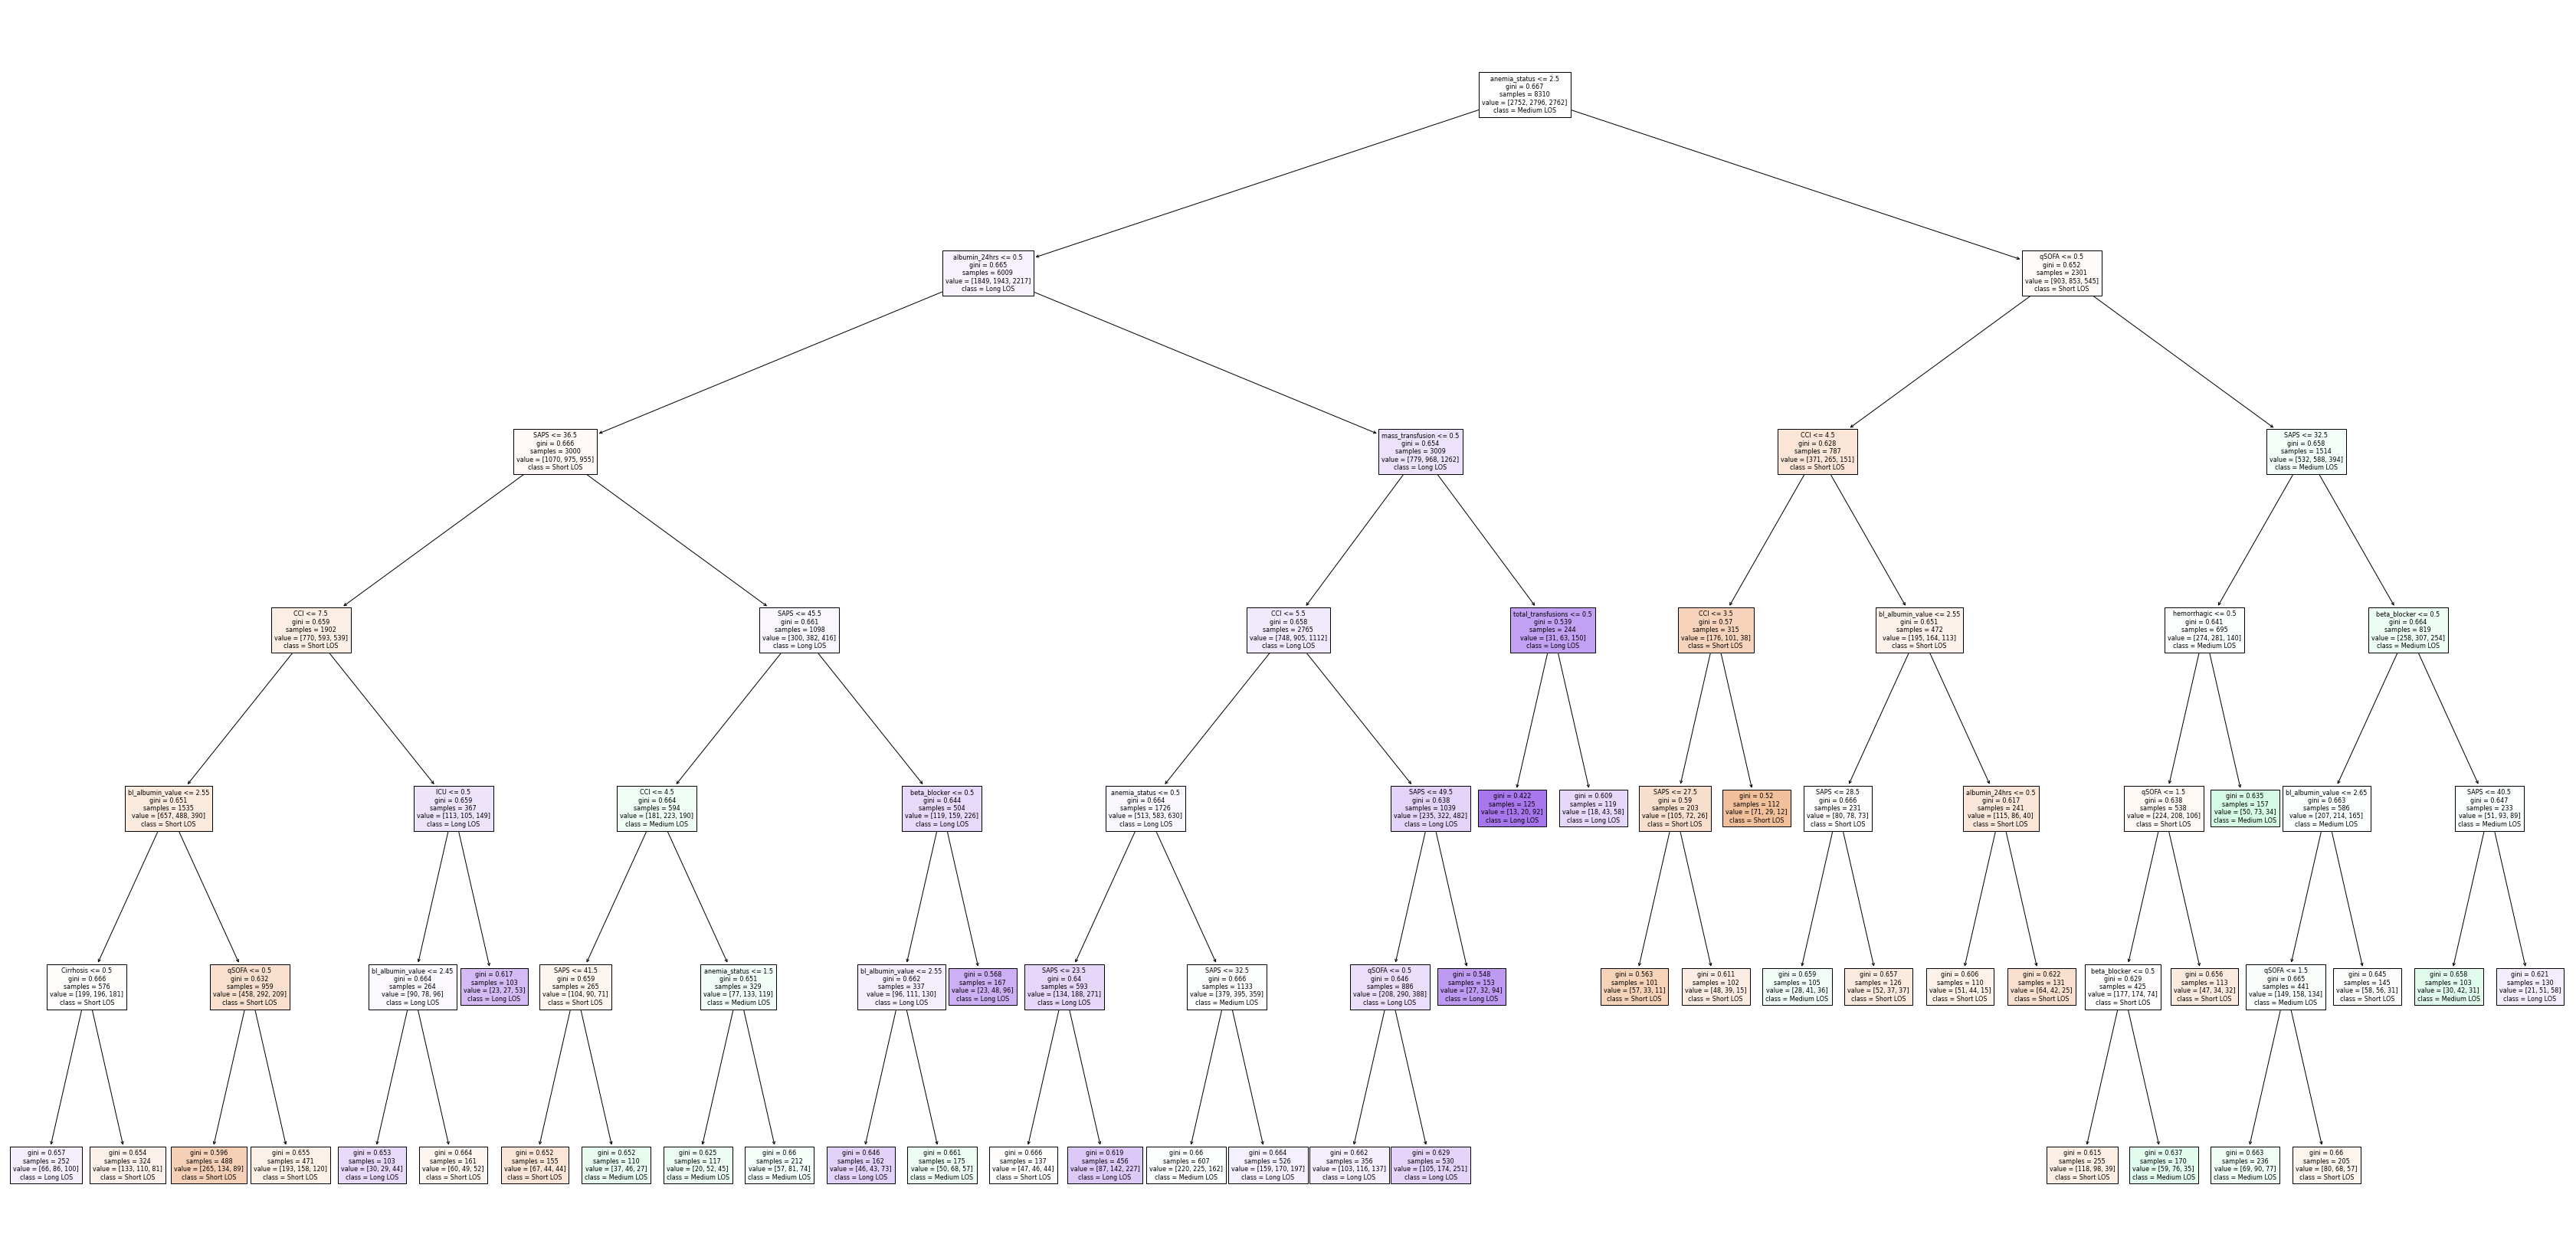

In [107]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [57]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D6_NCBL.png')

True

## 5: Decision Tree 

In [116]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.00920
Feature: mass_transfusion Score: 0.05206
Feature: total_transfusions Score: 0.02568
Feature: anemia_status Score: 0.21124
Feature: CCI Score: 0.12461
Feature: bl_albumin_value Score: 0.09587
Feature: qSOFA Score: 0.08933
Feature: Cirrhosis Score: 0.02036
Feature: beta_blocker Score: 0.07004
Feature: hemorrhagic Score: 0.00644
Feature: SAPS Score: 0.19539
Feature: albumin_24hrs Score: 0.09977


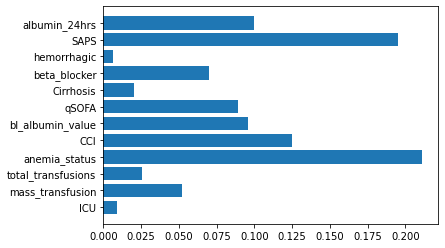

In [117]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [118]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [119]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1704  489  559]
 [1292  686  818]
 [ 959  477 1326]]


In [120]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.43      0.62      0.51      2752
           1       0.42      0.25      0.31      2796
           2       0.49      0.48      0.49      2762

    accuracy                           0.45      8310
   macro avg       0.45      0.45      0.43      8310
weighted avg       0.45      0.45      0.43      8310



In [121]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[455 118 129]
 [321 138 228]
 [254 133 302]]


In [122]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.44      0.65      0.53       702
           1       0.35      0.20      0.26       687
           2       0.46      0.44      0.45       689

    accuracy                           0.43      2078
   macro avg       0.42      0.43      0.41      2078
weighted avg       0.42      0.43      0.41      2078



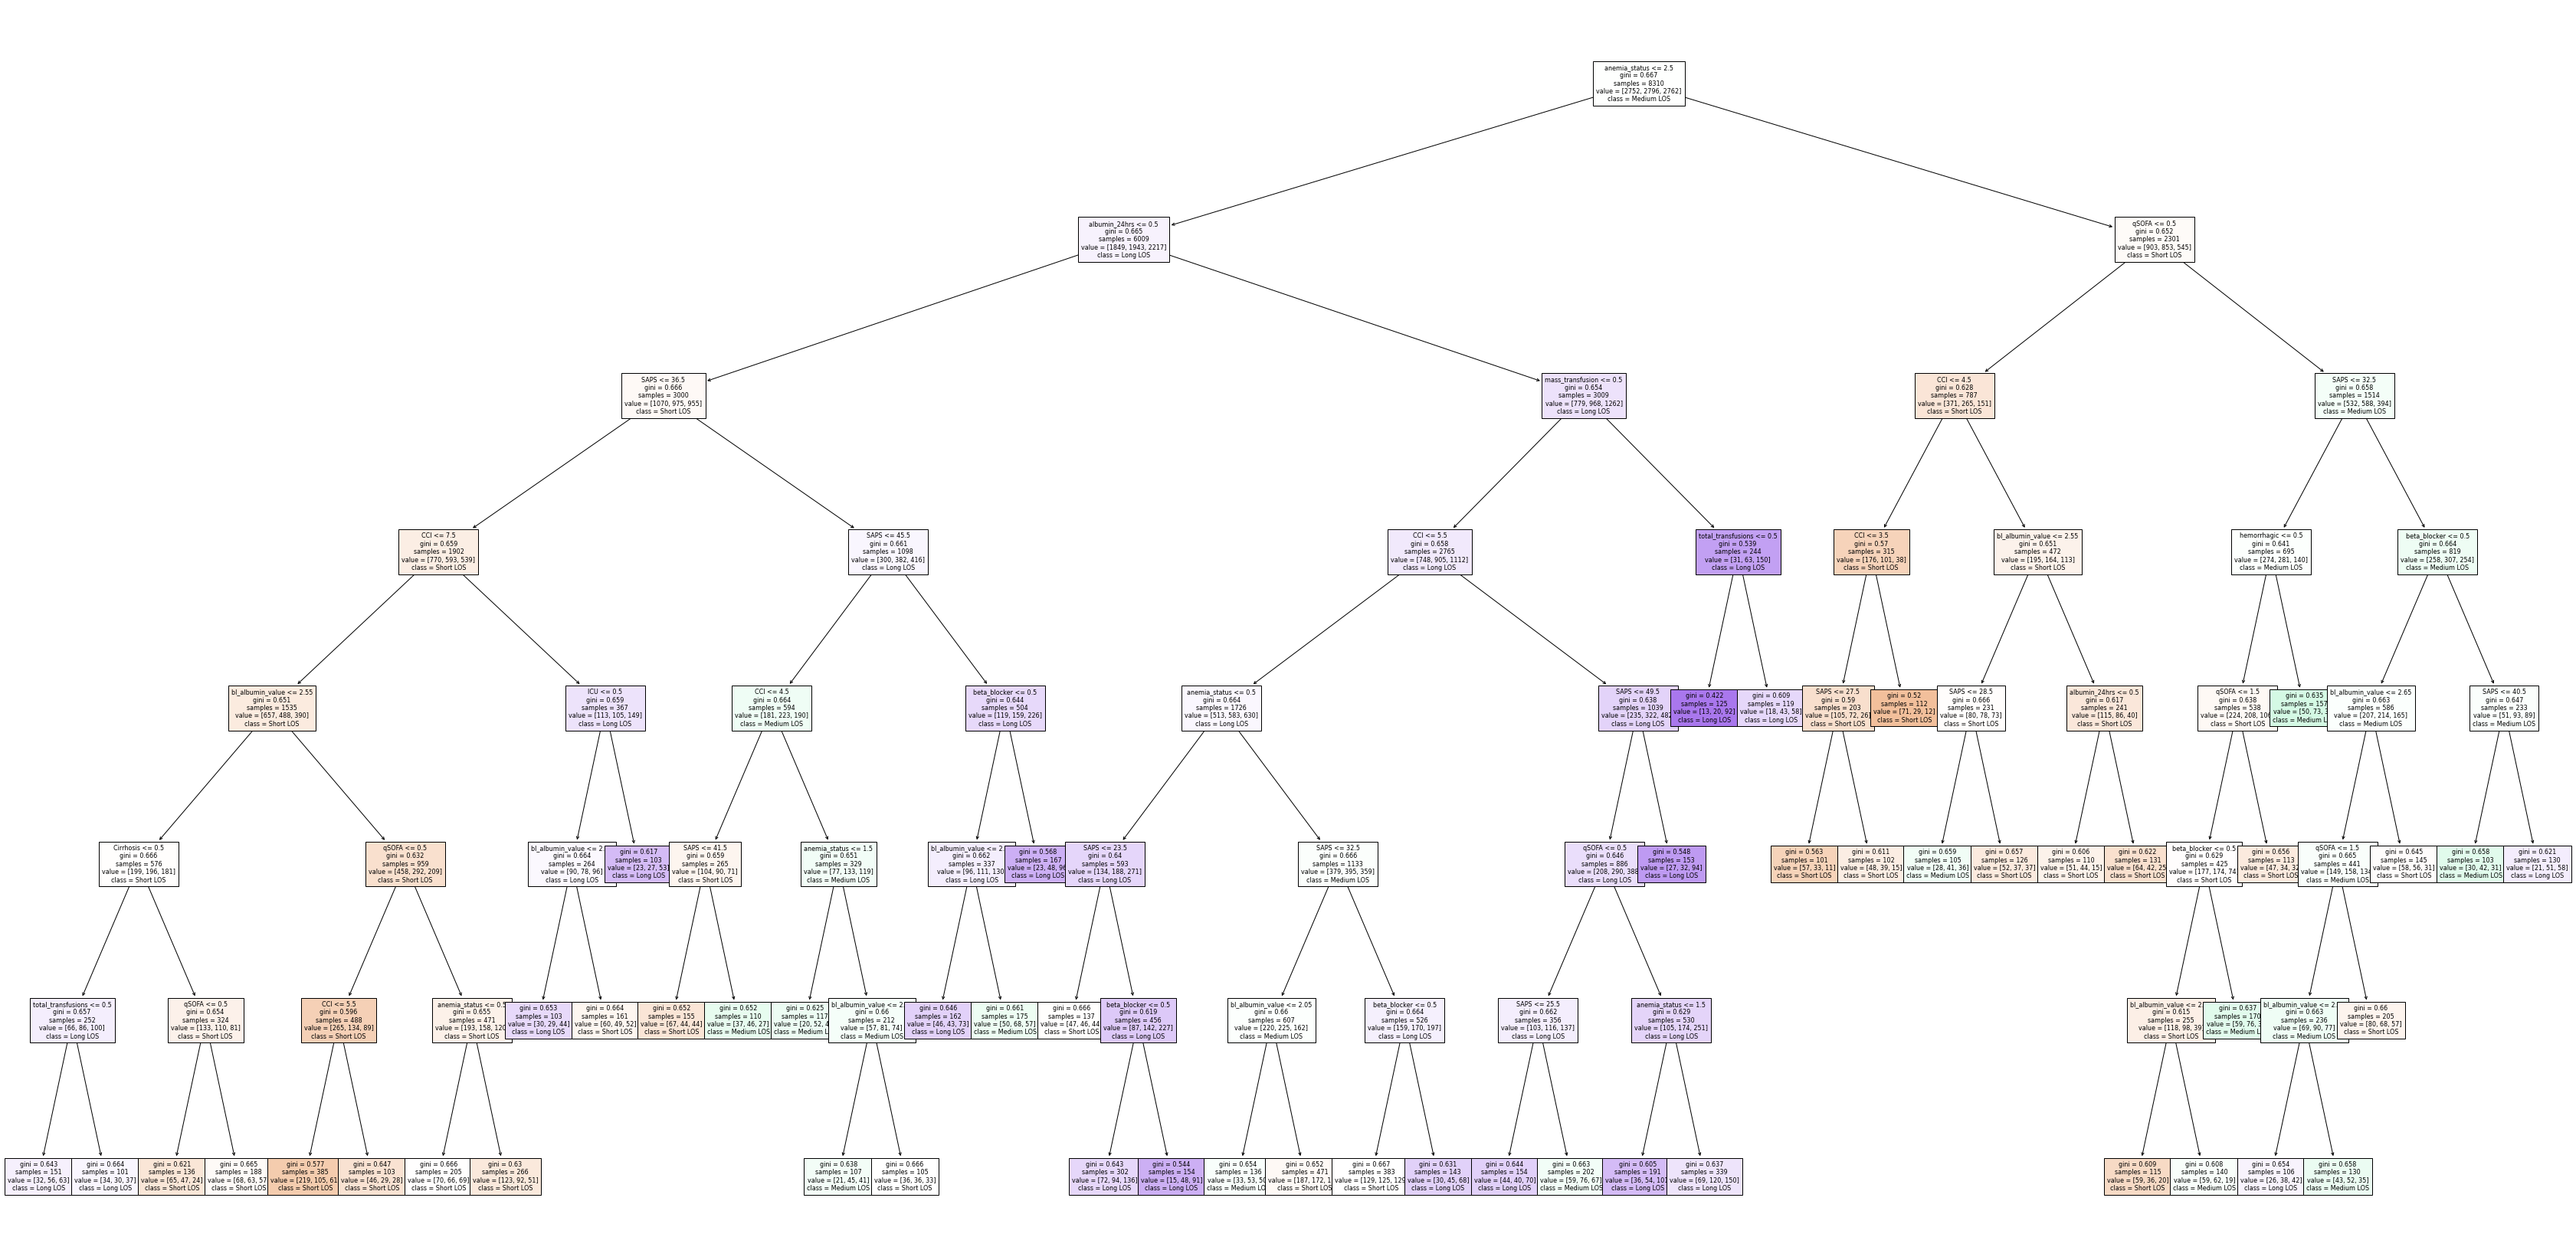

In [123]:
feature_names = X_train.columns.tolist()
class_names = ['Short LOS', 'Medium LOS', 'Long LOS']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [124]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('LOS_DT_D7_NCBL.png')

True

## Random Forest

In [67]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [68]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [69]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[18672   637  2957]
 [ 9614   836  3514]
 [ 6440   612  5605]]


In [70]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.54      0.84      0.66     22266
           1       0.40      0.06      0.10     13964
           2       0.46      0.44      0.45     12657

    accuracy                           0.51     48887
   macro avg       0.47      0.45      0.40     48887
weighted avg       0.48      0.51      0.45     48887



In [71]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4688  168  776]
 [2396  191  886]
 [1603  152 1362]]


In [72]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.54      0.83      0.65      5632
           1       0.37      0.05      0.10      3473
           2       0.45      0.44      0.44      3117

    accuracy                           0.51     12222
   macro avg       0.45      0.44      0.40     12222
weighted avg       0.47      0.51      0.44     12222



Feature: anemia_status Score: 0.16072
Feature: CCI Score: 0.41386
Feature: albumin_24hrs Score: 0.03637
Feature: qSOFA Score: 0.17950
Feature: SAPS Score: 0.20956


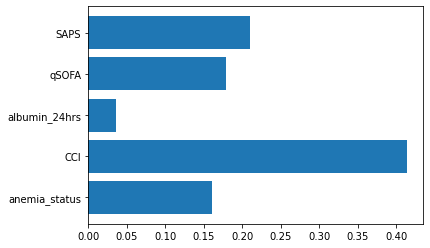

In [73]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()